In [5]:
!pip install datasets

In [6]:
pip install -U datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 14.4 MB/s eta 0:00:0000:01
  Attempting uninstall: datasets
    Found existing installation: datasets 4.4.2
    Uninstalling datasets-4.4.2:
      Successfully uninstalled datasets-4.4.2
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from datasets import load_dataset
ds = load_dataset("roneneldan/TinyStories")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00004-2d5a1467fff108(…):   0%|          | 0.00/249M [00:00<?, ?B/s]

data/train-00001-of-00004-5852b56a2bd28f(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/train-00002-of-00004-a26307300439e9(…):   0%|          | 0.00/246M [00:00<?, ?B/s]

data/train-00003-of-00004-d243063613e5a0(…):   0%|          | 0.00/248M [00:00<?, ?B/s]

data/validation-00000-of-00001-869c898b5(…):   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

In [9]:
!pip install tiktoken
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm   # progress bars

enc = tiktoken.get_encoding("gpt2")  # it is byte pair encoding

# Some functions from https://github.com/karpathy/nanoGPT/blob/master/data/openwebtext/prepare.py

def process(example):
    ids = enc.encode_ordinary(example['text']) # encode_ordinary ignores any special tokens
    out = {'ids': ids, 'len': len(ids)}
    return out

if not os.path.exists("train.bin"):
    tokenized = ds.map(
        process,
        remove_columns=['text'],
        desc="tokenizing the splits",
        num_proc=8,
        )
    # concatenate all the ids in each dataset into one large file we can use for training
    for split, dset in tokenized.items():
        arr_len = np.sum(dset['len'], dtype=np.uint64)
        filename = f'{split}.bin'
        dtype = np.uint16 # (can do since enc.max_token_value == 50256 is < 2**16)
        arr = np.memmap(filename, dtype=dtype, mode='w+', shape=(arr_len,))
        total_batches = 1024

        idx = 0
        for batch_idx in tqdm(range(total_batches), desc=f'writing {filename}'):
            # Batch together samples for faster write
            batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format('numpy')
            arr_batch = np.concatenate(batch['ids']) # flattening the sequences in batch to one array
            # Write into mmap
            arr[idx : idx + len(arr_batch)] = arr_batch # write batch to a memory mapped file
            idx += len(arr_batch)
        arr.flush() # this ensures all data is written to the disk

tokenizing the splits (num_proc=8):   0%|          | 0/2119719 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/21990 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing validation.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

In [10]:
import torch
def get_batch(split):
  # We create np.memmap every batch to avoid a memory leak
  if split =='train':
    data = np.memmap('train.bin', dtype = np.uint16, mode = 'r')
  else:
    data = np.memmap('validation.bin', dtype=np.uint16, mode='r')

  ix = torch.randint(len(data)-block_size, (batch_size,))
  x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
  y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])
  if device_type =='cuda':
    #pin arrays x,y, which allows to move them to GPU asynchronously
    x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
  else:
    x, y = x.to(device), y.to(device)
  return x,y

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None
    def forward(self, x):
        return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.flash = hasattr(F, 'scaled_dot_product_attention')
        if not self.flash:
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                       .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

        if self.flash:
            y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
        else:
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v

        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
    def forward(self, x):
        return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = LayerNorm(config.n_embd, config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln2 = LayerNorm(config.n_embd, config.bias)
        self.mlp = MLP(config)
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int
    vocab_size: int
    n_layer: int
    n_head: int
    n_embd: int
    dropout: float = 0.0
    bias: bool = True

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte=nn.Embedding(config.vocab_size, config.n_embd),
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.dropout),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=LayerNorm(config.n_embd, config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.transformer.wte.weight = self.lm_head.weight  # weight tying

        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size
        pos = torch.arange(0, t, dtype=torch.long, device=device)

        tok_emb = self.transformer.wte(idx)
        pos_emb = self.transformer.wpe(pos)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            return logits, loss
        else:
            logits = self.lm_head(x[:, [-1], :])
            return logits, None

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Generate tokens given a conditioning sequence.
        idx: Tensor of shape (B, T)
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


In [12]:
config = GPTConfig(
    vocab_size=50257,     # use the tokenizer's vocab size
    block_size=128,       # or whatever context size you're training with
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True
)

model = GPT(config)

In [13]:
def estimate_loss(model):
    out = {}
    model.eval()
    with torch.inference_mode():
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
    model.train()
    return out

In [14]:
# Training Config
import torch
from contextlib import nullcontext

learning_rate = 1e-4 #more stable training, earlier 1e-4
max_iters = 20000 #increase from 25000
warmup_steps = 1000 #smoother initial train, earlier 100
min_lr = 5e-4 #lower rate, earlier 5e-4
eval_iters = 500 # increased from 100
batch_size = 32 # changed from 16, better gradient estimate
block_size = 128 #changed from 64, capture longer range dependencies

gradient_accumulation_steps = 32 # reduced from 50

device =  "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler

# How to use autocast https://wandb.ai/wandb_fc/tips/reports/How-To-Use-Autocast-in-PyTorch--VmlldzoyMTk4NTky
#dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(42)

In [15]:
from torch.optim.lr_scheduler import LinearLR,SequentialLR, CosineAnnealingLR

##PUT IN WEIGHT DECAY, CHANGED BETA2 to 0.95
optimizer =  torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9) #weight decay for regularization

scheduler_warmup = LinearLR(optimizer, total_iters = warmup_steps) #Implement linear warmup
scheduler_decay = CosineAnnealingLR(optimizer,T_max = max_iters - warmup_steps, eta_min = min_lr) #Implement lr decay
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps]) #Switching from warmup to decay

# https://stackoverflow.com/questions/72534859/is-gradscaler-necessary-with-mixed-precision-training-with-pytorch
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

/tmp/ipykernel_55/2132813893.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))


In [16]:
best_val_loss = float('inf')
best_model_params_path = "best_model_params.pt"
train_loss_list, validation_loss_list = [], []

# Ensure model is on the correct device
model = model.to(device)

# In your training loop
for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        # Ensure estimate_loss uses the correct device
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        validation_loss_list += [losses['val']]

        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model.state_dict(), best_model_params_path)

    # Ensure X and y are on the correct device
    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/20000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: train loss 9.4171, val loss 9.4240
The current learning rate: 0.00007


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: train loss 8.4629, val loss 8.4670
The current learning rate: 0.00010
Epoch 1500: train loss 7.4926, val loss 7.4913
The current learning rate: 0.00010
Epoch 2000: train loss 6.6445, val loss 6.6484
The current learning rate: 0.00010
Epoch 2500: train loss 5.9576, val loss 5.9560
The current learning rate: 0.00011
Epoch 3000: train loss 5.4578, val loss 5.4524
The current learning rate: 0.00011
Epoch 3500: train loss 5.0443, val loss 5.0467
The current learning rate: 0.00012
Epoch 4000: train loss 4.7332, val loss 4.7305
The current learning rate: 0.00012
Epoch 4500: train loss 4.4929, val loss 4.4962
The current learning rate: 0.00013
Epoch 5000: train loss 4.2872, val loss 4.2781
The current learning rate: 0.00014
Epoch 5500: train loss 4.1089, val loss 4.1095
The current learning rate: 0.00015
Epoch 6000: train loss 3.9608, val loss 3.9647
The current learning rate: 0.00016
Epoch 6500: train loss 3.8283, val loss 3.8280
The current learning rate: 0.00018
Epoch 7000: trai

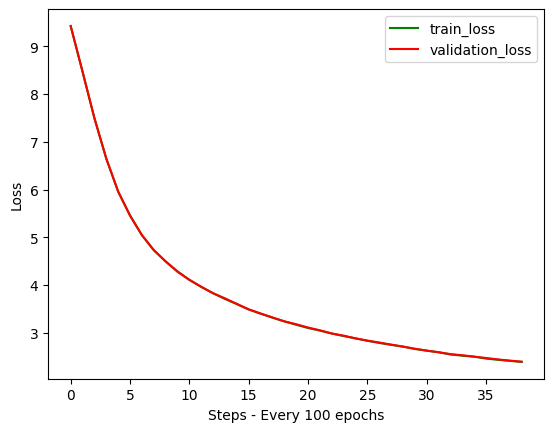

In [17]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in validation_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r', label='validation_loss')
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
#Load the model
model = GPT(config)  # re-create the model with same config
device =  "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device))) # load best model states

<All keys matched successfully>

In [19]:
sentence = "Once upon a time there was a pumpkin."
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim = 0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))

Once upon a time there was a pumpkin. You are in your home. I am cold."

The triangle didn't want a treat. It made a loud yell.

The pumpkin catches a gorilla. What are together that bounce at me? We have to sleep."

They both give the nightmares some sandwiches and shirt. When the shark was dancing.

"What do you want?" perched said the squash. "We lost it," he said.

"Feufumber is hurt of our boo! I love you not!"

The cricket licked theirhungy said, "It is normal. You need to wear it. You need to go home so he should have gotten your food now. And you have to be gentle and share them to wait or wash your pieces. You are a good friend."

The crab smiles. He hugs Lisa and licked her. He shows them each to Lily. He is the duck faster and flaps his neck.

"Here, let coming
